In [1]:
#imports
import numpy as np
import csv
import os
import matplotlib.pyplot as plt

In [2]:
#read fluxim n, k file
def read_nk_file(input_file):
    wl=[]
    n=[]
    k=[]
    with open(input_file, newline = '') as file:                                                                                          
        file_reader = csv.reader(file, delimiter='\t')
        for line in file_reader:
            try:
                #print(line)
                wl.append(float(line[0]))
                n.append(float(line[1]))
                k.append(float(line[2]))
            except:
                continue
    return np.flip(1.2398/(1e-3*np.array(wl))), np.flip(np.array(n)), np.flip(np.array(k)), np.array(wl)

In [3]:
#input files
GaAs_file = "data_GaAs/GaAs.nk"
GaSb_file = "data_GaSb/GaSb.nk"
#output file
GaAsSb_file = "GaAsSb_62.nk"

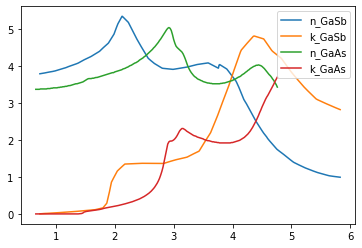

In [4]:
#read and plot imported data
eV_GaSb, n_GaSb, k_GaSb, wl_GaSb = read_nk_file(GaSb_file)
eV_GaAs, n_GaAs, k_GaAs, wl_GaAs = read_nk_file(GaAs_file)
#plot
plt.plot(eV_GaSb,n_GaSb,label="n_GaSb")
plt.plot(eV_GaSb,k_GaSb,label="k_GaSb")
plt.plot(eV_GaAs,n_GaAs,label="n_GaAs")
plt.plot(eV_GaAs,k_GaAs,label="k_GaAs")
plt.legend()

In [5]:
#what are the available energy ranges? we do this with the wavelength as the wavelength is our "input" resolution
print(max(wl_GaAs))
print(min(wl_GaAs))
print(max(wl_GaSb))
print(min(wl_GaSb))

1878.68
260.49
1699.8
212.8


In [6]:
#bring all data to the same axis
eV = np.flip(1.2398/(1e-3*np.arange(np.around(min(wl_GaAs),1),np.around(max(wl_GaSb),1),1)))
n_GaSb_i, k_GaSb_i = np.interp(eV,eV_GaSb,n_GaSb), np.interp(eV,eV_GaSb,k_GaSb) #works only with increasing x
n_GaAs_i, k_GaAs_i = np.interp(eV,eV_GaAs,n_GaAs), np.interp(eV,eV_GaAs,k_GaAs)

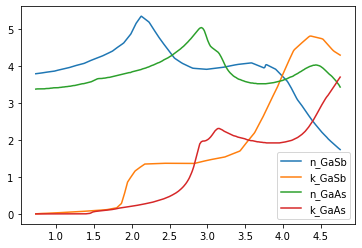

In [7]:
#%matplotlib qt
#plot and determine the points visually
plt.plot(eV,n_GaSb_i,label="n_GaSb")
plt.plot(eV,k_GaSb_i,label="k_GaSb")
plt.plot(eV,n_GaAs_i,label="n_GaAs")
plt.plot(eV,k_GaAs_i,label="k_GaAs")
plt.legend()

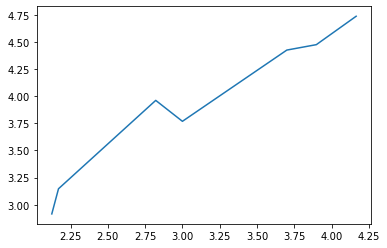

In [8]:
#list of critical points
e_s=np.array([2.124, 2.169, 2.821, 3.00, 3.7, 3.898, 4.165])
E_l=np.array([2.915, 3.147, 3.962, 3.769, 4.426, 4.476, 4.738])
plt.plot(e_s,E_l)

In [9]:
def find_index(array,value):
    i=0
    #print(value)
    while i<len(array)+2:
        if np.abs(array[i]-value)<0.01:
            return i
        else:
            i+=1
    return i 

In [10]:
def which_interval(array_e, array_E, value, all_energy):
    i=0
    #print(value)
    if value <= array_e[0]:
        #print("0 interval")
        return all_energy[0], array_e[0], all_energy[0], array_E[0],
    elif value > array_e[-1]:
        #print("inf interval")
        return array_e[-1], all_energy[-1], array_E[-1], all_energy[-1]
    else:
        i+=1
    while i>-1:
        #print(i)
        if array_e[i-1]<value<=array_e[i]:
            #print("intermediate interval")
            return array_e[i-1], array_e[i], array_E[i-1], array_E[i]
        else:
            i+=1

In [11]:
#interpolation function definition
def M(energy_value):
    lower_e, upper_e, lower_E, upper_E = which_interval(e_s, E_l, energy_value, eV)
    return lower_E+(upper_E-lower_E)*((energy_value-lower_e)/(upper_e-lower_e))

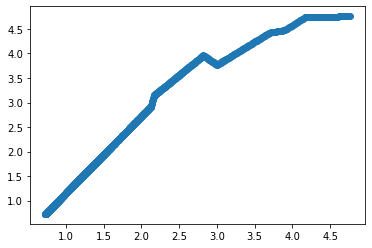

In [12]:
val_M=[]
for energy in eV:
    val_M.append(M(energy))
plt.scatter(eV,val_M)

In [13]:
#bandgap function
def Eg_GaAsSb(x):
    if x<=0.3:
        return 1.424-1.9*x+1.2*x**2
    else:
        print("Oops!  That was no valid number.  Try again with x<=0.3")

In [14]:
#bandgap function
def Eg_GaAsSb(x):
    return 1.424-1.9*x+1.2*x**2


In [15]:
print(Eg_GaAsSb(0.062))
Eg_GaAs=1.424
Eg_GaSb=0.726

1.3108128000000001


In [16]:
#scaled composition parameter
def I(x):
    return 1-(Eg_GaAs-Eg_GaAsSb(x))/(Eg_GaAs-Eg_GaSb)

In [22]:
#interpolated n
def interpolated_n(x):
    morphed_n=[]
    morphed_k=[]
    morphed_eV=[]
    for index in np.arange(len(eV)):
        morphed_E = M(eV[index])
        #print(morphed_E)
        #print(eV[index])
        index_E = find_index(eV,morphed_E)
        #print(eV[index],morphed_E)
        temp_E=(1-I(x))*eV[index]+I(x)*morphed_E
        temp_n=(1-I(x))*n_GaSb_i[index]+I(x)*n_GaAs_i[index_E]
        temp_k=(1-I(x))*k_GaSb_i[index]+I(x)*k_GaAs_i[index_E]
        morphed_k.append(temp_k)
        morphed_n.append(temp_n)
        morphed_eV.append(temp_E)
    return morphed_eV, morphed_n, morphed_k

In [28]:
morphed_eV, morphed_n, morphed_k = interpolated_n(0.062)

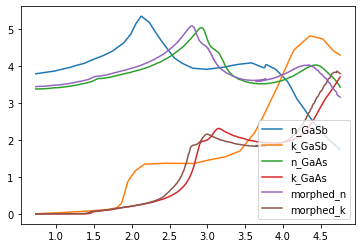

In [31]:
#plot and determine the points visually
plt.plot(eV,n_GaSb_i,label="n_GaSb")
plt.plot(eV,k_GaSb_i,label="k_GaSb")
plt.plot(eV,n_GaAs_i,label="n_GaAs")
plt.plot(eV,k_GaAs_i,label="k_GaAs")
plt.plot(morphed_eV,morphed_n,label="morphed_n")
plt.plot(morphed_eV,morphed_k,label="morphed_k")
plt.legend()

In [34]:
wl_export = 1.2398/np.flip(morphed_eV)*1000
n_export = np.flip(morphed_n)
k_export = np.flip(morphed_k)

In [35]:
#save data into file
np.savetxt(GaAsSb_file,np.dstack((wl_export,n_export,k_export))[0],fmt=['%.1f','%.4f','%.4f'], delimiter="\t")

In [33]:
wl_export

array([0.00590059, 0.00589625, 0.00589195, ..., 0.00090602, 0.00090523,
       0.00090444])